In [39]:
import networkx as nx
from RJW import *
import seaborn as sns
from custom_svc import *
from ot_distances import RJW_distance
import matplotlib.pyplot as plt
from graph import  Graph
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC



In [40]:
np.random.seed(50)

X_2_train = []
for _ in range(200): 
    
    points = np.random.rand(15,2)
    # graph avec 3nn sur ce jeu de points
    G = nx.Graph()
    G.add_nodes_from(range(len(points)))
    for i in range(len(points)):
        distces = np.linalg.norm(points-points[i],axis=1)
        distces[i] = np.inf
        nn = np.argsort(distces)[:2]
        G.add_edges_from([(i,nn[0]),(i,nn[1])])
    
    y = points
    nx.set_node_attributes(G, dict(zip(G.nodes(),[points[i] for i in G.nodes()])), 'y')
    X_2_train.append(G)

X_3_train = []

for _ in range(200):
    
    points = np.random.rand(15,2)
    # graph avec 3nn sur ce jeu de points
    G = nx.Graph()
    G.add_nodes_from(range(len(points)))
    for i in range(len(points)):
        distces = np.linalg.norm(points-points[i],axis=1)
        distces[i] = np.inf
        nn = np.argsort(distces)[:3]
        G.add_edges_from([(i,nn[0]),(i,nn[1]), (i,nn[2])])
    y = points
    nx.set_node_attributes(G, dict(zip(G.nodes(),[points[i] for i in G.nodes()])), 'y')
    X_3_train.append(G)

X_2_test = []


for _ in range(50):
    
    points = np.random.rand(15,2)
    # graph avec 3nn sur ce jeu de points
    G = nx.Graph()
    G.add_nodes_from(range(len(points)))
    for i in range(len(points)):
        distces = np.linalg.norm(points-points[i],axis=1)
        distces[i] = np.inf
        nn = np.argsort(distces)[:2]
        G.add_edges_from([(i,nn[0]),(i,nn[1])])
    y = points
    nx.set_node_attributes(G, dict(zip(G.nodes(),[points[i] for i in G.nodes()])), 'y')
    X_2_test.append(G)


X_3_test = []


for _ in range(50):
    
    points = np.random.rand(15,2)
    # graph avec 3nn sur ce jeu de points
    G = nx.Graph()
    G.add_nodes_from(range(len(points)))
    for i in range(len(points)):
        distces = np.linalg.norm(points-points[i],axis=1)
        distces[i] = np.inf
        nn = np.argsort(distces)[:3]
        G.add_edges_from([(i,nn[0]),(i,nn[1]), (i,nn[2])])
    y = points
    nx.set_node_attributes(G, dict(zip(G.nodes(),[points[i] for i in G.nodes()])), 'y')
    X_3_test.append(G)



Exemple de graphe

In [41]:
nx.is_connected(X_2_train[0])

False

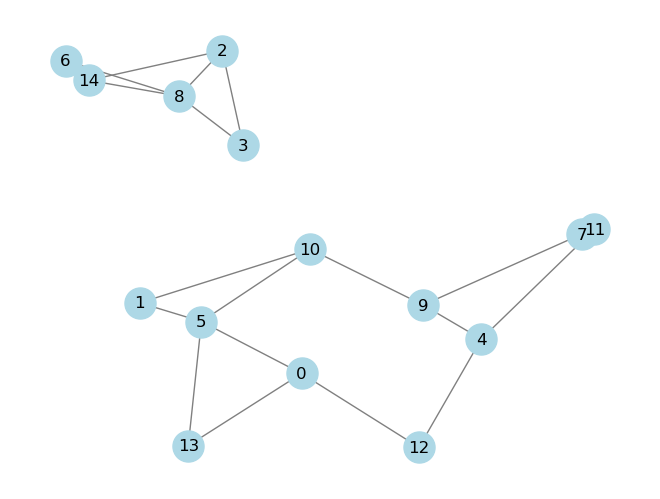

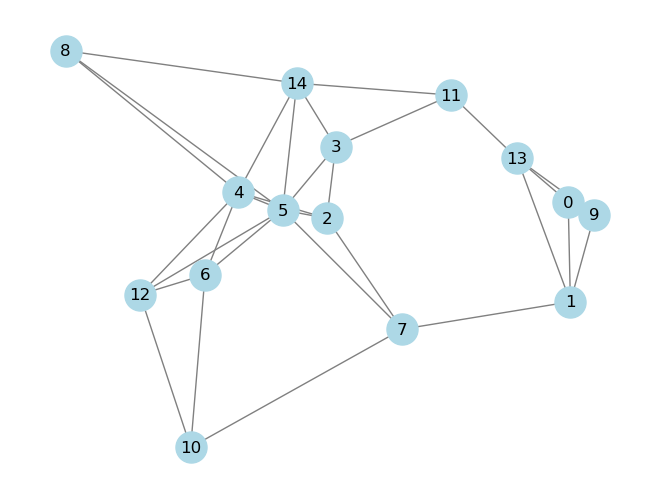

In [42]:

G_first = X_2_train[0]
positions = nx.get_node_attributes(G_first, 'y')
nx.draw(G_first, pos=positions, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

G_first = X_3_train[0]
positions = nx.get_node_attributes(G_first, 'y')
nx.draw(G_first, pos=positions, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

In [43]:
count=0
for i in range(len(X_2_train)): 
    if nx.is_connected(X_2_train[i]) : 
        count+=1
print(str(100*count/len(X_2_train)) + '% of the 2nn graphs are connected')
count=0
for i in range(len(X_3_train)): 
    if nx.is_connected(X_3_train[i]) : 
        count+=1
print(str(100*count/len(X_3_train)) + '% of the 3nn graphs are connected')


56.5% of the 2nn graphs are connected
90.0% of the 3nn graphs are connected


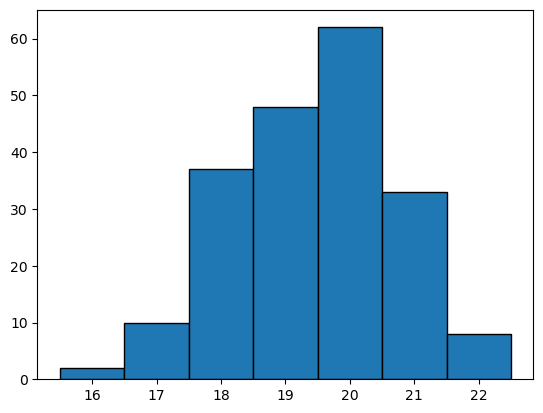

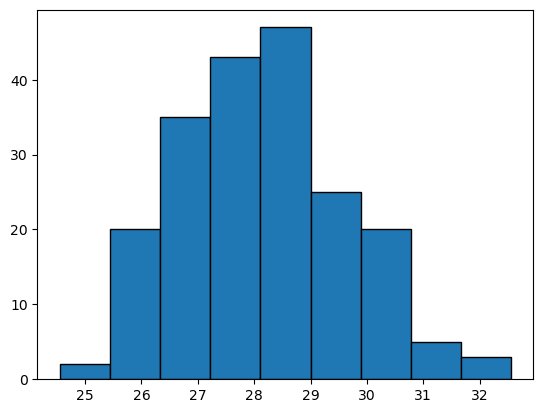

mean number of edges in 2nn graphs : 19.45
mean number of edges in 3nn graphs : 28.555


In [44]:
edges_2=[len(X.edges()) for X in X_2_train]
plt.hist(edges_2, bins=7, edgecolor='black', align = 'left')    
plt.show()

edges_3=[len(X.edges()) for X in X_3_train]
plt.hist(edges_3, bins=9, edgecolor='black', align  = 'left')
plt.show()

print('mean number of edges in 2nn graphs : ' + str(np.mean(edges_2)))
print('mean number of edges in 3nn graphs : ' + str(np.mean(edges_3)))


In [45]:
X_train, y_train = (X_2_train + X_3_train),np.array( [0]*len(X_2_train) + [1]*len(X_3_train))

X_test, y_test = (X_2_test + X_3_test), np.array([0]*len(X_2_test) + [1]*len(X_3_test))

In [46]:
# mean number of edges
mean_edges = np.mean([len(X.edges()) for X in X_2_train])
print('mean number of edges in 2nn graphs :', mean_edges)


mean_edges = np.mean([len(X.edges()) for X in X_3_train])
print('mean number of edges in 2nn graphs :', mean_edges)


mean number of edges in 2nn graphs : 19.45
mean number of edges in 2nn graphs : 28.555


In [47]:
def convert_list_in_array(l): 
    array = np.empty(len(l), dtype=object)
    for i in range(len(l)):
        array[i] = l[i]
    return array

In [48]:
X_train_bis = []
X_test_bis = []

for g in X_train: 
    my_graph = Graph(g)
    my_graph.distance_matrix()
    X_train_bis.append(my_graph)
for g in X_test: 
    my_graph = Graph(g)
    my_graph.distance_matrix()
    X_test_bis.append(my_graph)


X_train_bis = convert_list_in_array(X_train_bis)
X_test_bis = convert_list_in_array(X_test_bis)



In [49]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
dist= RJW_distance()
dist_mat = np.zeros((len(X_train_bis), len(X_train_bis)))

for i in tqdm(range(len(X_train_bis))):
    for j in range(len(X_train_bis)):
        # print(i,j)
        try : 
            dist_mat[i, j] = dist.graph_d(X_train_bis[i], X_train_bis[j])
        except :
            dist_mat[i, j] = 1000



 67%|██████▋   | 268/400 [07:16<03:40,  1.67s/it]

10


100%|██████████| 400/400 [10:53<00:00,  1.63s/it]

f1 score on validation set :  0.810126582278481
accuracy on validation set :  0.8125


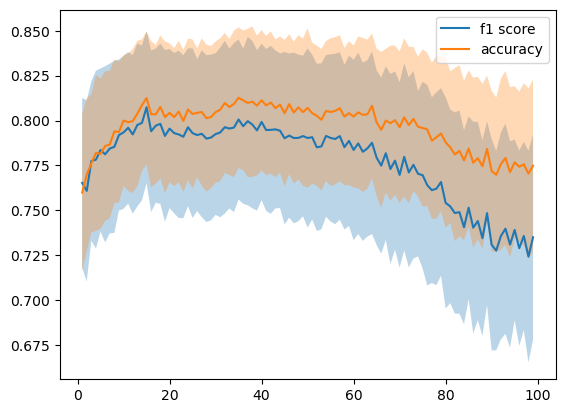

In [68]:


# train val 
all_f1=[]
all_accs=[]
for n_neigh in range(1, 100) : 
    # print('n neigh', n_neigh)
    accs=[]
    f1s=[]
    for _ in range(250) : 
        index_train = np.random.choice(range(len(X_train_bis)), int(0.8*len(X_train_bis)), replace=False)
        index_val = [i for i in range(len(X_train_bis)) if i not in index_train]
        dist_mat_train = dist_mat[index_train][:, index_train]
        y_train_bis = y_train[index_train]
        dist_mat_val = dist_mat[index_val][:, index_train]
        y_val_bis = y_train[index_val]
        knn = KNeighborsClassifier(n_neighbors=n_neigh, metric='precomputed')
        knn.fit(dist_mat_train, y_train_bis)
        y_pred = knn.predict(dist_mat_val)
        f1 = f1_score(y_val_bis, y_pred)
        # print('f1 score on validation set : ', f1)
        acc = np.mean(y_val_bis == y_pred)
        # print('accuracy on validation set : ', acc)
        f1s.append(f1)
        accs.append(acc)
    all_f1.append((f1s))
    all_accs.append((accs))


# plot mean and std 
mean_f1 = np.mean(all_f1, axis=1)
std_f1 = np.std(all_f1, axis=1)
mean_acc = np.mean(all_accs, axis=1)
std_acc = np.std(all_accs, axis=1)
plt.plot(range(1, 100), mean_f1, label='f1 score')
plt.fill_between(range(1, 100), mean_f1-std_f1, mean_f1+std_f1, alpha=0.3)
plt.plot(range(1, 100), mean_acc, label='accuracy')
plt.fill_between(range(1, 100), mean_acc-std_acc, mean_acc+std_acc, alpha=0.3)
plt.legend()
plt.show()


In [69]:
np.argmax(mean_f1)

14

In [70]:
k_opt = 14
dist_mat_test = np.zeros((len(X_test_bis), len(X_train_bis)))
for i in tqdm(range(len(X_test_bis))):
    for j in range(len(X_train_bis)):
        dist_mat_test[i, j] = dist.graph_d(X_test_bis[i], X_train_bis[j])
knn = KNeighborsClassifier(n_neighbors=k_opt, metric='precomputed')
knn.fit(dist_mat, y_train)
y_pred = knn.predict(dist_mat_test)
f1 = f1_score(y_test, y_pred)
acc = np.mean(y_test == y_pred)
print('f1 score on test set : ', f1)

100%|██████████| 100/100 [02:42<00:00,  1.62s/it]

f1 score on test set :  0.6857142857142857


In [71]:
print(acc)

0.67


In [13]:
with open('./params.txt', 'w') as f : 
    f.write('1.9 \n')
    f.write('3.9 \n')


In [ ]:
for g_w in [0.1, 0.5, 1, 2, 5, 10]:
    for g_s in [0.1, 0.5, 1, 2, 5, 10]:
        with open('./params.txt', 'w') as f : 
            f.write(str(g_w) + '\n')
            f.write(str(g_s) + '\n')
        print('g_w =', g_w, 'g_s =', g_s)
        classifier = Graph_RJW_SVC_Classifier()
        t1 = time.time()
        classifier.fit(X_train_bis, y_train)
        prediction_was = classifier.predict(X_test_bis)
        t2 = time.time()
        print('prediction : ',prediction_was)
        print('true labels : ',y_test)
        print('f1 score : ',f1_score(y_test, prediction_was))
        print('accuracy', np.mean(prediction_was == y_test))
        with open('./results.txt', 'a') as f : 
            f.write('g_w = ' + str(g_w) + ' g_s = ' + str(g_s) + ' f1 score : ' + str(f1_score(y_test, prediction_was)) + ' accuracy : ' + str(np.mean(prediction_was == y_test)) + ' time : ' + str(t2-t1) + '\n')
        # clf = SVC(kernel=RJW_kernel, C=1)
        # clf.fit(X_train_bis, y_train)
        # y_pred = clf.predict(X_test_bis)
        # print('f1 score :', f1_score(y_test, y_pred))
        # print('accuracy :', np.mean(y_test == y_pred))
        # print('---------------------------------')

In [ ]:

classifier = Graph_RJW_SVC_Classifier()
classifier.fit(X_train_bis, y_train)
# print('score : ',classifier.score(X_test_bis, y_test))


In [12]:
prediction_was = classifier.predict(X_test_bis)
print('prediction : ',prediction_was)
print('true labels : ',y_test)

2
NonConvergenceError for  <graph.Graph object at 0x00000235BB1391F0> <graph.Graph object at 0x00000235BAEEF5E0>
InfiniteException : Preds error because nan
prediction :  [-10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10
 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10
 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10
 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10
 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10
 -10 -10 -10 -10 -10 -10 -10 -10 -10 -10]
true labels :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [13]:
# import f1 score
print('f1 score : ',f1_score(y_test, prediction_was))
print('accuracy', np.mean(prediction_was == y_test))

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [14]:
# random forest 
classifier = RandomForestClassifier()
classifier.fit([X_train_bis[i].distance_matrix()[0].flatten() for i in range(len(X_train_bis))], y_train)
prediction_rf = classifier.predict([X_test_bis[i].distance_matrix()[0].flatten() for i in range(len(X_test_bis))])
print('prediction : ',prediction_rf)
print('true labels : ',y_test)
print('f1 score : ',f1_score(y_test, prediction_rf))
print('accuracy', np.mean(prediction_rf == y_test))



prediction :  [0 0 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 1 0 0 1 1 1 0 1 1 1 0 0 1 1 1 0 1 1 1
 0 0 0 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1 1 1 0 1 0 0 1 1]
true labels :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
f1 score :  0.6666666666666666
accuracy 0.68


In [15]:
# kernel method with gaussiao kernel
classifier = SVC(kernel='rbf')
classifier.fit([X_train_bis[i].distance_matrix()[0].flatten() for i in range(len(X_train_bis))], y_train)
prediction_gauss = classifier.predict([X_test_bis[i].distance_matrix()[0].flatten() for i in range(len(X_test_bis))])
print('prediction : ',prediction_gauss)
print('true labels : ',y_test)
print('f1 score : ',f1_score(y_test, prediction_gauss))
print('accuracy', np.mean(prediction_gauss == y_test))


prediction :  [0 0 1 1 0 0 0 1 1 1 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 1 1 1 0 0 1 1 0 0 1 1 1 0 1 1 1
 0 0 0 0 1 1 1 1 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 1 0]
true labels :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
f1 score :  0.5681818181818182
accuracy 0.62
